In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import h5py

In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# STATE OF THE ART MODEL

In [ ]:
from math import sqrt

import torch
from torch import nn


class ConvReLU(nn.Module):
    def __init__(self, channels: int) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False)
        self.relu = nn.ReLU(True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.relu(out)

        return out


class VDSR(nn.Module):
    def __init__(self) -> None:
        super(VDSR, self).__init__()
        # Input layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), (1, 1), (1, 1), bias=False),
            nn.ReLU(True),
        )

        # Features trunk blocks
        trunk = []
        for _ in range(18):
            trunk.append(ConvReLU(64))
        self.trunk = nn.Sequential(*trunk)

        # Output layer
        self.conv2 = nn.Conv2d(64, 1, (3, 3), (1, 1), (1, 1), bias=False)

        # Initialize model weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.trunk(out)
        out = self.conv2(out)

        out = torch.add(out, identity)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0.0, sqrt(2 / (module.kernel_size[0] * module.kernel_size[1] * module.out_channels)))

# DATA ACQUISITION AND PREPROCESSING

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][idx] / 255., 0), np.expand_dims(f['hr'][idx] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
class EvalDataset(torch.utils.data.Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][str(idx)][:, :] / 255., 0), np.expand_dims(f['hr'][str(idx)][:, :] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Replace 'yourfile.h5' with the path to your H5 file
with h5py.File('/content/drive/MyDrive/VDSR/91-image_x2.h5', 'r') as f:
    # Assuming 'image_data' is the key in your H5 file that contains images
    dataset_shape = f['lr'].shape

print("Shape of the dataset:", dataset_shape)

Shape of the dataset: (21910, 33, 33)


In [ ]:
train_dataset = TrainDataset('/content/drive/MyDrive/VDSR/91-image_x2.h5')
train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=16,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)
# train_dataloader_iter = iter(train_dataloader)
# batch_input_data, batch_target_labels = next(train_dataloader_iter)

# # Print the shape of the target labels
# print(batch_target_labels.shape)
# print(batch_input_data.shape)

In [ ]:
eval_dataset = EvalDataset('/content/drive/MyDrive/VDSR/Set5_x2.h5')
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

# MODEL ARCHITECTURE CHANGE AND FINE TUNING

In [ ]:
from tqdm import tqdm
model = VDSR()
epochs = 4
batch_size = 50
lr = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_dataset = TrainDataset('/content/drive/MyDrive/VDSR/91-image_x2.h5')
train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)


for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for lr_images, hr_images in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs}'):

    # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(lr_images)

      # Compute loss
      loss = criterion(outputs, hr_images)

      # Backward pass and optimize
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

# Print epoch statistics
print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}')

Epoch 4/4: 100%|██████████| 438/438 [30:43<00:00,  4.21s/it]

Epoch [4/4], Loss: 0.000875779057676972


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/VDSR/Models/VDSR_weights_h5.pth')

In [ ]:
model = VDSR()
model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights_h5.pth'))

<All keys matched successfully>

# MODEL EVALUATION

In [ ]:
from tqdm import tqdm
model.eval()

# Criterion for loss
criterion = nn.MSELoss()

# Accumulators
running_loss = 0.0
psnr_score_loss = 0
total_images = 0

with torch.no_grad():  # Deactivate autograd for evaluation
    for inputs, labels in tqdm(eval_dataloader, desc='Evaluating', leave=False):
        # Forward pass: compute the model's predictions for the inputs
        preds = model(inputs).clamp(0.0, 1.0)

        loss = criterion(preds, labels)
        running_loss += loss.item()

        pred_i = preds.squeeze()
        label_i = labels.squeeze()
        input_i = inputs.squeeze()

        # Convert to numpy arrays
        pred_np = pred_i.cpu().numpy()
        label_np = label_i.cpu().numpy()
        input_np = input_i.cpu().numpy()

        # Calculate PSNR for generated and original LR images
        psnr_score_hr_gen = psnr(pred_np, label_np)
        psnr_score_hr_lr = psnr(input_np, label_np)
        psnr_score_loss += psnr_score_hr_gen - psnr_score_hr_lr
        total_images += 1

average_loss = running_loss / total_images
average_psnr_diff = psnr_score_loss / total_images

print(f'Test Loss: {average_loss:.6f}')
print(f'Average PSNR Difference: {average_psnr_diff:.6f}')

Test Loss: 0.000285
Average PSNR Difference: 2.722168


In [ ]:
# for data in eval_dataloader:

#   inputs, labels = data

#   inputs = inputs
#   labels = labels
#   preds = model(inputs).clamp(0.0, 1.0)

#   loss = criterion(preds, labels)
#   running_loss += loss.item()

#   preds = preds.detach().numpy()
#   preds = preds.squeeze(0)

#   inputs = inputs.detach().numpy()
#   inputs = inputs.squeeze(0)
#   inputs = inputs.transpose((1, 2, 0))

#   labels = labels.detach().numpy()
#   labels = labels.squeeze(0)
#   labels = labels.transpose((1, 2, 0))

#   preds = preds.transpose((1, 2, 0))

#   psnr_score_hr_gen = psnr(preds, labels)
#   psnr_score_hr_lr = psnr(inputs, labels)
#   psnr_score_loss += psnr_score_hr_gen - psnr_score_hr_lr
#   total_images += 1

#   print(f'Test Loss: {running_loss/total_images}')
#   print(f'Average PSNR difference: {psnr_score_loss/total_images}')

Test Loss: 0.00014139202539809048
Average PSNR difference: 1.3467901213537132
Test Loss: 0.00011322760474286042
Average PSNR difference: 2.6391101572863356
Test Loss: 0.000285479936186069
Average PSNR difference: 3.2612697017662255
Test Loss: 0.0002796023381961277
Average PSNR difference: 2.663081057349028
Test Loss: 0.0002846711708116345
Average PSNR difference: 2.7221679244656976


# INFERENCE, OPTIMIZATION AND REAL TIME TEST

In [ ]:
import numpy as np
import PIL.Image as pil_image
def convert_rgb_to_ycbcr(img):
  if type(img) == np.ndarray:
      y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
      cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
      cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
      return np.array([y, cb, cr]).transpose([1, 2, 0])
  elif type(img) == torch.Tensor:
      if len(img.shape) == 4:
          img = img.squeeze(0)
      y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
      cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
      cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
      return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
  else:
      raise Exception('Unknown Type', type(img))

def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))

In [ ]:
model.eval()
scale = 2
image_file = '/content/drive/MyDrive/VDSR/Train/myButterfly.png'
hr_image_cv = cv2.imread(image_file)
# image_file = '/content/drive/MyDrive/SRCNN/Train/t1.bmp'
hr_image_cv = cv2.imread(image_file)
print(hr_image_cv.shape)
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float32')/255.0
image = pil_image.open(image_file).convert('RGB')

image_width = (image.width // scale) * scale
image_height = (image.height // scale) * scale
image = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
image = image.resize((image.width // scale, image.height // scale), resample=pil_image.BICUBIC)
image = image.resize((image.width * scale, image.height * scale), resample=pil_image.BICUBIC)
image.save(image_file.replace('.', '_bicubic_x{}.'.format(scale)))

image = np.array(image).astype(np.float32)
imagepsnr = image/255.0
ycbcr = convert_rgb_to_ycbcr(image)

y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
y = y.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y).clamp(0.0, 1.0)

(536, 685, 3)


In [ ]:
print(preds.shape)
preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
# output = output.astype('float32')/255.0
# print(output)
# print(output.shape)
output = pil_image.fromarray(output)
output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))

torch.Size([1, 1, 536, 684])


In [ ]:
# output = pil_image.fromarray(output)
# output.save(image_file.replace('.', '_srcnn_x{}.'.format(scale)))

In [ ]:
# print(output.shape)
# print(image.shape)

hr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/myButterfly.png')
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float32')/255.0

generated_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/myButterfly_srcnn_x2.png')
generated_image_rgb = cv2.cvtColor(generated_image_cv, cv2.COLOR_BGR2RGB)
generated_image_rgb = generated_image_rgb.astype('float32')/255.0

lr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/myButterfly_bicubic_x2.png')
lr_image_rgb = cv2.cvtColor(lr_image_cv, cv2.COLOR_BGR2RGB)
lr_image_rgb = lr_image_rgb.astype('float32')/255.0
# print("Signal to noise ratio between generated image and HR image: " + str(psnr(hr_image_rgb, generated_image_rgb)))
# print("Signal to noise ratio between LR image and HR image: " +str(psnr(hr_image_rgb, lr_image_rgb)))

In [ ]:
# hr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/butterfly_GT.bmp')
# hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
# hr_image_rgb = hr_image_rgb.astype('float32')/255.0

# generated_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/butterfly_GT_srcnn_x2.bmp')
# generated_image_rgb = cv2.cvtColor(generated_image_cv, cv2.COLOR_BGR2RGB)
# generated_image_rgb = generated_image_rgb.astype('float32')/255.0

# lr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/butterfly_GT_bicubic_x2.bmp')
# lr_image_rgb = cv2.cvtColor(lr_image_cv, cv2.COLOR_BGR2RGB)
# lr_image_rgb = lr_image_rgb.astype('float32')/255.0

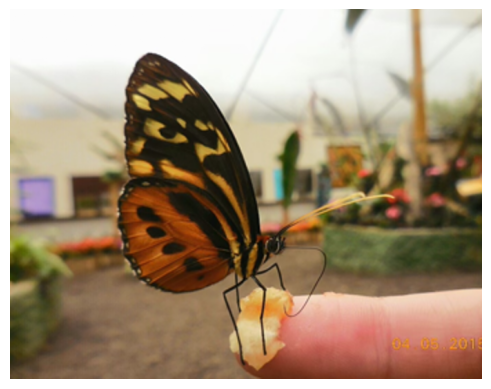

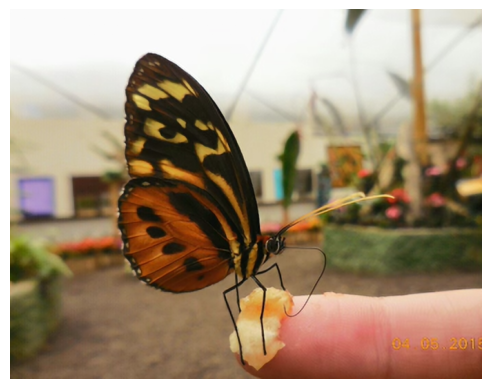

In [ ]:
plt.imshow(lr_image_rgb)
plt.axis('off')  # Turn off axis
plt.show()


plt.imshow(generated_image_rgb)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
# print(output.shape)
# print(image.shape)

hr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train/butterfly_GT_bicubic_x2.bmp')
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float32')/255.0

generated_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Test/butterfly_GT_bicubic_x2.bmp')
# plt.imshow(generated_image_cv)
# plt.axis('off')  # Turn off axis
# plt.show()
generated_image_rgb = cv2.cvtColor(generated_image_cv, cv2.COLOR_BGR2RGB)
generated_image_rgb = generated_image_rgb.astype('float32')/255.0

lr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Test/butterfly_GT_bicubic_x2.bmp')
lr_image_rgb = cv2.cvtColor(lr_image_cv, cv2.COLOR_BGR2RGB)
lr_image_rgb = lr_image_rgb.astype('float32')/255.0
print("Signal to noise ratio between generated image and HR image: " + str(psnr(hr_image_rgb, generated_image_rgb)))
print("Signal to noise ratio between LR image and HR image: " +str(psnr(hr_image_rgb, lr_image_rgb)))

In [ ]:
# output_image_np = preds.squeeze().cpu().numpy().transpose((1, 2, 0))
# print(output_image_np.shape)
plt.imshow(generated_image_rgb)
plt.axis('off')  # Turn off axis
plt.show()

NameError: name 'generated_image_rgb' is not defined

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
model = VDSR()
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
image = Image.open(lr_image_path).convert('RGB')
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)
y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
input_tensor = y.unsqueeze(0).unsqueeze(0)
print(input_tensor.shape)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
traced_model = torch.jit.script(model, input_tensor)
traced_model.save("/content/drive/MyDrive/VDSR/Models/VDSR_weights_script_h5.pt")

In [ ]:
import time
model  = VDSR()
# loaded_model = torch.jit.load("/content/drive/MyDrive/VDSR/Models/VDSR_weights_script_h5.pt")
# model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights_h5.pth'))
# loaded_model.load_state_dict(model.state_dict())
loaded_model = torch.jit.load("/content/drive/MyDrive/VDSR/Models/VDSR_weights_script_h5.pt")
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights_h5.pth'))
# loaded_model.load_state_dict(model.state_dict())

lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
image = Image.open(lr_image_path).convert('RGB')
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)
y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
input_tensor = y.unsqueeze(0).unsqueeze(0)
print(input_tensor.shape)
overall = 0
for i in range(50):
  start_time = time.time()

  with torch.no_grad():
      output = loaded_model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

In [ ]:
import time
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
model  = VDSR()
model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights_h5.pth'))
image = Image.open(lr_image_path).convert('RGB')
image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)
y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y)
input_tensor = y.unsqueeze(0).unsqueeze(0)
print(input_tensor.shape)
overall = 0
for i in range(50):
  start_time = time.time()

  with torch.no_grad():
      output = model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

torch.Size([1, 1, 400, 400])
5.293742833137512
